# Notebook reviewing the unbalanced vynil disk

This notebook reviews the problem of the unbalanced vynil disk, a simple linear system with a non-linear deviation due to an imbalance in the disk manufacturing, causing it to spin unevenly when put in motion. The goal is to design a controller capable of handling the problem, with the long-term goal being to create c-code for the issue. (NOTE: All parameters are estimates.)

In [57]:
import matplotlib.pyplot as plt #matlplotlip for plotting
import numpy as np              #numpy for numerical operations
from models.VinylDynamics import UnbalancedVinyl #importing the UnbalancedVinyl class

# Explanation
The model below contains the _UnbalancedVinyl_ class, which contains the dynamics of the plant.

The solution can be called using _UnbalancedVinyl().solve_equations_, which employs scipy.integrate, to generate a solution.
You can also define a controller function _u(error,theta,dtheta)_

Look at the example below for more information

In [58]:
## First defining controller as a function
K_p = 1e3
K_d = 1e2
def PID_controller(error, th, dth):
    input = K_p*error - K_d * dth
    return input

## Defining reference signal, in terms of desired attained theta
def constant_dtheta(t):
    rpm = 33.3
    theta_desired = (rpm/60*2*np.pi)*t #converting rpm to the correct rad/s
    return theta_desired
#parsing parameter values and the controller function to the class
g = 9.81    # Gravitational acceleration (m/s^2)
l = 0.01     # Displacement of the C.O.M. of the vinyl
k = 0       # Spring constant (no physical interpretation) (1/s^2)
d = 0.15    # Linear drag coefficient (1/s)                (non-linear to be added) 
x0 = [1, 0] # Initial condition ([rad,rad/s])

unb_vinyl = UnbalancedVinyl(g=g, l=l, k=0, d=0.05, x0=x0, controller = PID_controller, reference = constant_dtheta)

#Generating a solution using the solve_equations object
simulation_length = 5 #simulation time in seconds
solver_steps = 1e3
sol = unb_vinyl.solve_equations(t_len=simulation_length, solver_steps = int(solver_steps))

controller is applied
reference is changed


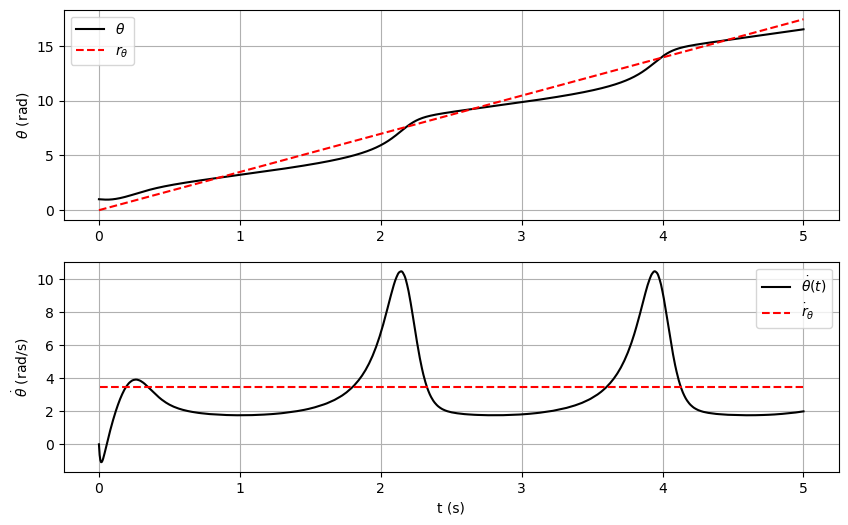

In [64]:
truncate_plot = False ## OPTIONAL: Bounding theta and theta_ref between [-pi, pi] in the plot

t = sol.t
if truncate_plot:
    plot_theta = ((sol.y[0,:] + np.pi) % (2 * np.pi)) - np.pi
    plot_reference = ((constant_dtheta(sol.t) + np.pi) % (2 * np.pi)) - np.pi
    limits = [-np.pi,np.pi]
else:
    plot_theta = sol.y[0,:]
    plot_reference = constant_dtheta(sol.t)
    limits = [None,None]
reference_dt = np.divide(constant_dtheta(sol.t),sol.t+1e-16) #adding a miniscule value to prevent the divison going wack at t=0

## Plotting results ##
plt.figure(figsize=(10, 6))
## Subplot 1: the angle (normalized to ticks)
ax1 = plt.subplot(2, 1, 1)
ax1.plot(sol.t, plot_theta,label=r'$\theta$',color='black')
ax1.plot(sol.t, plot_reference,label=r'$r_{\theta}$',color='red',linestyle='--')

#plot settings first subplot
ax1.set_ylim(limits)
ax1.set_ylabel(r"$\theta$ (rad)")
ax1.grid('on')
ax1.legend(loc='best');

## Subplot 2: angular velocity
ax2 = plt.subplot(2, 1, 2)
ax2.plot(sol.t, sol.y[1,:],label=r'$\dot{\theta}(t)$',color='black')
ax2.plot(sol.t[1:], reference_dt[1:], label=r'$\dot{r}_{\theta}$',color='red',linestyle='--')

#plot settings second subplot
ax2.set_xlabel('t (s)')
ax2.set_ylabel(r"$\dot{\theta}$ (rad/s)")
ax2.grid('on')
ax2.legend();
